In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install patchify
from patchify import patchify
import numpy as np
from matplotlib import pyplot as plt
import tifffile as tiff

set_of_images = tiff.imread('/content/drive/MyDrive/GLIM_Research_Internship/Semantic Segmentation/training.tif') # path of training images.tiff
set_of_masks = tiff.imread('/content/drive/MyDrive/GLIM_Research_Internship/Semantic Segmentation/training_groundtruth.tif') # path of training masks.tiff


In [3]:
print("No of images : ", len(set_of_images))
print("No of masks : ", len(set_of_masks))

No of images :  165
No of masks :  165


In [4]:
set_of_images.shape
# 165 images
# Dimension of each is 768*1024

(165, 768, 1024)

In [5]:
for img in range(set_of_images.shape[0]):

  curr_image = set_of_images[img]
  patches = patchify(curr_image, (256, 256), step=256)

  for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        single_patch_img = patches[i,j,:,:]
        tiff.imwrite('/content/drive/MyDrive/GLIM_Research_Internship/Semantic Segmentation/processed/images/' + 'image_' + str(img) + "_" + str(i)+str(j)+ ".tif", single_patch_img)


In [6]:
for mask_ptr in range(set_of_masks.shape[0]):
  curr_mask = set_of_masks[mask_ptr]
  patches = patchify(curr_mask, (256,256), step=256)

  for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):

      single_patch_mask = patches[i,j,:,:]
      tiff.imwrite('/content/drive/MyDrive/GLIM_Research_Internship/Semantic Segmentation/processed/masks/' + 'mask_' + str(mask_ptr) + '_' + str(i)+str(j) + '.tif', single_patch_mask)
      single_patch_mask = single_patch_mask/255

In [7]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def UNET(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    x = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model


In [8]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

image_directory = '/content/drive/MyDrive/GLIM_Research_Internship/Semantic Segmentation/processed/images/'
mask_directory = '/content/drive/MyDrive/GLIM_Research_Internship/Semantic Segmentation/processed/masks/'

SIZE = 256
image_dataset = []
mask_dataset = []

images = os.listdir(image_directory)
for i, image_name in enumerate(images):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))


image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)


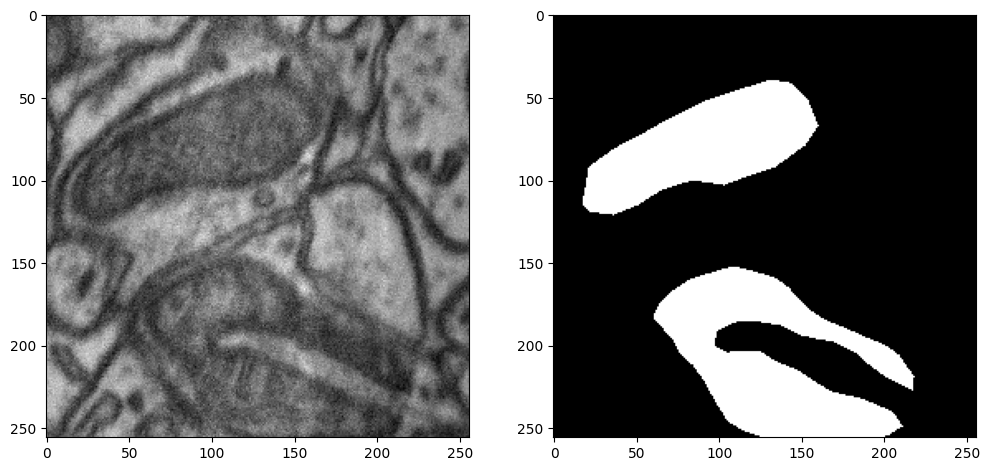

256 256 1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 5s 60ms/step - loss: 0.0214 - accuracy: 0.9918
Accuracy =  99.17640089988708 %


In [9]:
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

height = image_dataset.shape[1]
width  = image_dataset.shape[2]
channels = image_dataset.shape[3]

print(image_dataset.shape[1], image_dataset.shape[2], image_dataset.shape[3])

def get_model():
    return UNET(height, width, channels)

model = get_model()

history = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    shuffle=False)

model.save('/content/drive/MyDrive/GLIM_Research_Internship/Semantic Segmentation/processed/simple_unet_weights/mitochondria_test.hdf5')

_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


In [10]:
history.history

{'loss': [0.24452336132526398,
  0.12841945886611938,
  0.07023908942937851,
  0.0435633584856987,
  0.02761412039399147,
  0.025692736729979515,
  0.018828637897968292,
  0.017214439809322357,
  0.014958193525671959,
  0.018527017906308174,
  0.014405782334506512,
  0.013095139525830746,
  0.012339465320110321,
  0.012660264037549496,
  0.011845146305859089,
  0.01167634129524231,
  0.01200816035270691,
  0.011647982522845268,
  0.01707436516880989,
  0.014204577542841434],
 'accuracy': [0.9408800005912781,
  0.9517078399658203,
  0.9723901152610779,
  0.9831187725067139,
  0.9891020655632019,
  0.9900220632553101,
  0.9925326704978943,
  0.9932264685630798,
  0.9939988255500793,
  0.9927149415016174,
  0.9942089915275574,
  0.994674026966095,
  0.9949449896812439,
  0.9948197603225708,
  0.9951032996177673,
  0.9951819181442261,
  0.9950574040412903,
  0.9951764345169067,
  0.9934884905815125,
  0.9943291544914246],
 'val_loss': [0.2020062506198883,
  0.22690744698047638,
  0.0975819

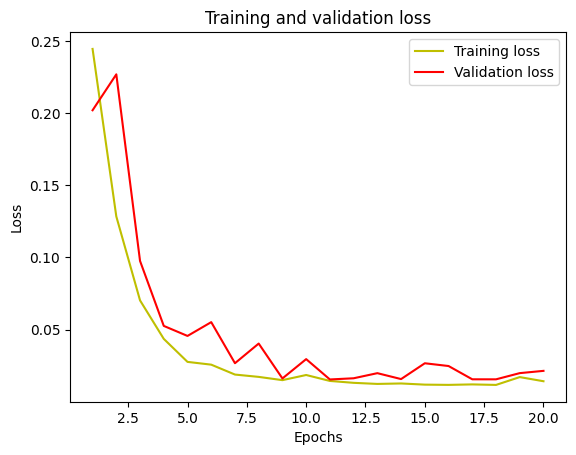

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

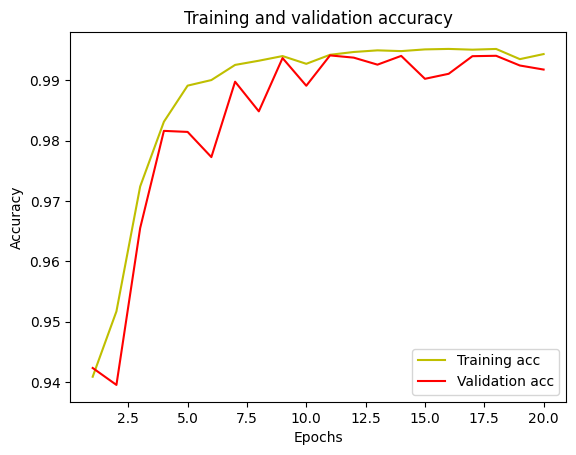

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

7/7 [==============================] - 1s 60ms/step
IoU socre is:  0.8697317867555998


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 16)         160       ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 256, 256, 16)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 16)         2320      ['dropout_9[0][0]']           
                                                                                            

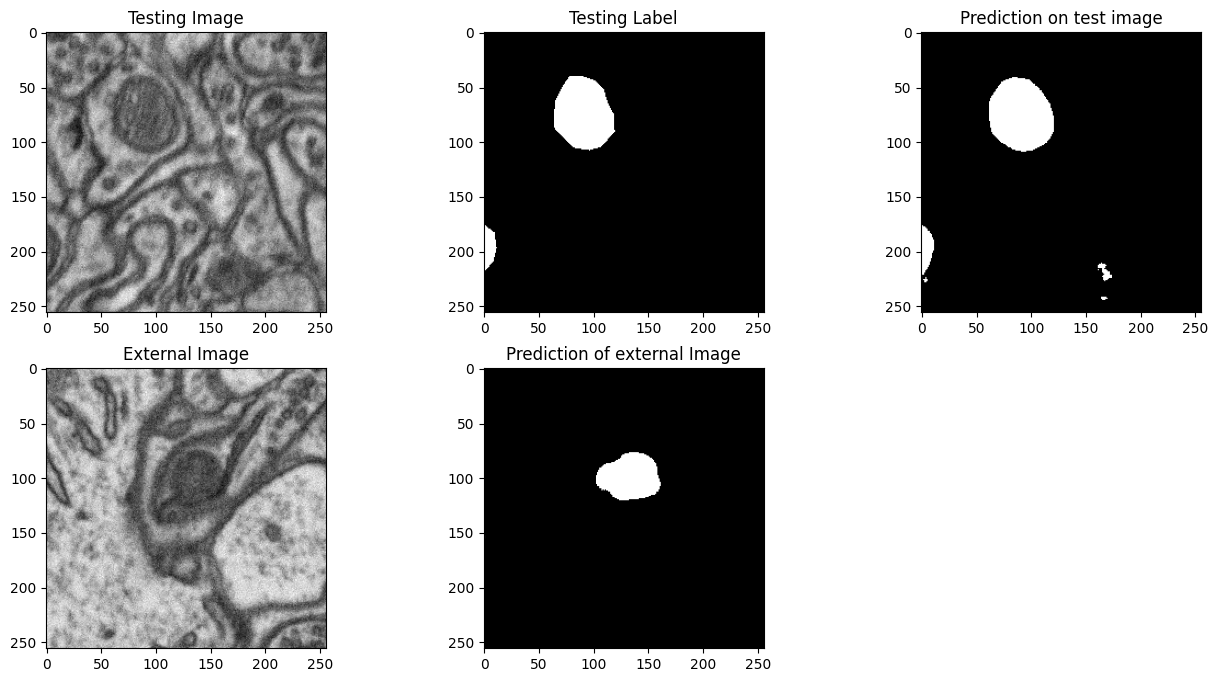

In [14]:
# Example
model = get_model()
model.load_weights('/content/drive/MyDrive/GLIM_Research_Internship/Semantic Segmentation/processed/simple_unet_weights/mitochondria_test.hdf5') #Trained for 50 epochs and then additional 100

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

test_img_other = cv2.imread('/content/drive/MyDrive/GLIM_Research_Internship/Semantic Segmentation/processed/sample_test/image_164_21.tif', 0)
test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.show()